In [1]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

Note: you may need to restart the kernel to use updated packages.


In [4]:
dataset_path = "dataset/lfw-deepfunneled/lfw-deepfunneled/"

In [5]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("dataset/peopleDevTrain.csv")

In [6]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

842
868


<AxesSubplot:>

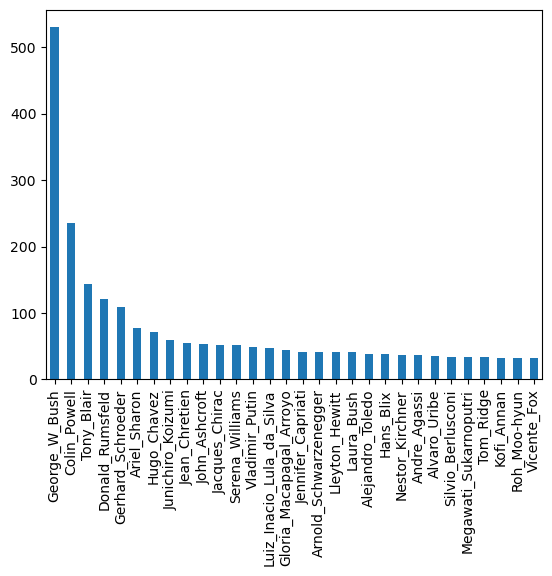

In [7]:
image_paths['name'].value_counts()[:30].plot(kind = "bar")

In [8]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [9]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [10]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [11]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as 
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function 
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is 
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have 
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g. 
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('bush/',dir_name)):
            shutil.os.mkdir(os.path.join('bush/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('bush/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('bush/',dir_name,data_type))
        path_from = os.path.join('dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('bush/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [15]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [17]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('bush/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('bush/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('bush/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [25]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # set steps per epoch equal to the number of training images
                                             steps_per_epoch = 678,
                                             # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/8
678/678 [==============================] - 15s 20ms/step - loss: 0.4710 - accuracy: 0.7832 - val_loss: 0.4956 - val_accuracy: 0.7588
